<a href="https://colab.research.google.com/github/16shulockm/robotics_556/blob/main/Copy_of_ME556_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem 1:

Implement a particle filter for the vehicle model and input from the last homework, using $dt=0.1$ and process noise and measurement noise normally distributed with a variance of $0.05$.

**Turn In: A plot of the particles every $1$ second for a total of 6 seconds. Include your estimate at every $dt$ seconds.**

It should look something like the picture below, where each color represents a snapshot of the particles at a particular time. The black line is the state estimate of $x$ and $y$ every $dt$ seconds. Notice that after 6 seconds, the particle cloud is clustered very narrowly around the estimate.
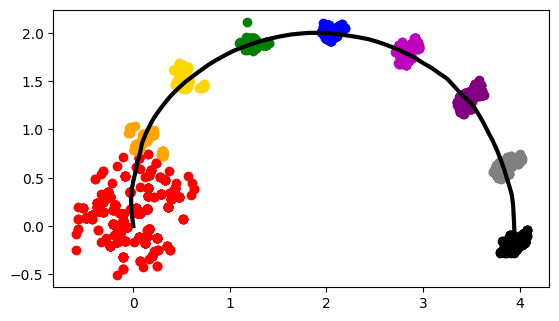


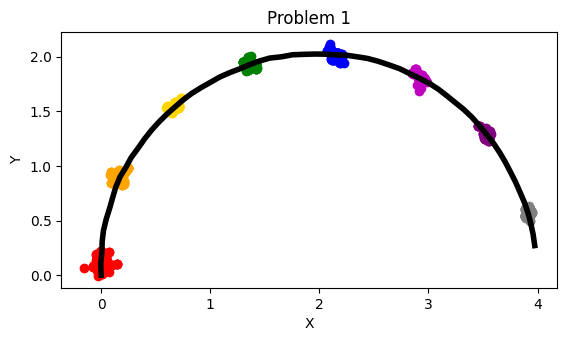

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
from random import random

N = 100  # Choose enough particles for a good estimate
DT = 0.1
SIGMA = 0.05
obs_model = np.eye(3)  #fully observable
###begin Simulation setup#####
def dynam(x, command):
    u = command
    xnew = np.zeros(3)
    xnew[0] = x[0] + np.cos(x[2]) * u[0] * DT
    xnew[1] = x[1] + np.sin(x[2]) * u[0] * DT
    xnew[2] = x[2] + (u[1] * DT)
    return xnew
#####end simulations setup###

def estimate(Xt, w):
    return np.average(Xt, axis=0, weights=w) #you may want a function the returns the estimate for convenience

def resample(w):
    ind = np.random.choice(len(w), size=N, p=w/w.sum())
    return ind

InitCon = np.array([0., 0., np.pi/2])
U =np.array([1,-0.5])

Xbart = np.random.normal(InitCon, SIGMA, (N, 3)) # initialize particles from normal distribution centered at InitCon
#print(Xbart)
Xt = Xbart
xcurr = InitCon  #this is for the simulation, Do NOT Touch
x_est = xcurr #initialize your estimate
colors = ['r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray', 'k']  # Handy way to get different colors

#for 6 second
for i in range(60):  # 60 iterations bc of dt
    ###simulation start###
    #system moves
    xcurr = dynam(xcurr, U+np.random.normal(0,SIGMA,2))
    #print(xcurr)
    # Take a new measurement
    z =xcurr + np.random.normal(0,SIGMA,3)
    ####simulation end###

    #update particles according to transition (dynamics)
    Xbart = np.array([dynam(x, U + np.random.normal(0, SIGMA, 2)) for x in Xt])
    #apply measurement model to each particle
    zt = [obs_model@x for x in Xbart];
    #reweight the particles based on measurement
    #print(w)
    w = np.array([multivariate_normal.pdf(z, mean=z_particle, cov=SIGMA) for z_particle in zt])
    w = w / np.sum(w)  # Normalize
    yourestimate = estimate(Xbart, w)  # Make an estimate with the new weights added to Xbart
    x_est = np.vstack([x_est, yourestimate])

    indices = resample(w)
    Xt = Xbart[indices]  # Resample

    #plot about every second
    if i%8==0:  # every 0.8 seconds
        plt.scatter(np.transpose(Xt)[0],np.transpose(Xt)[1],c=colors[round(i/8)])
        #print(i)

plt.plot(np.transpose(x_est)[0], np.transpose(x_est)[1], '-k', linewidth=4.0)
plt.gca().set_aspect('equal')
plt.title("Problem 1")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Problem 2:

Implement the extended Kalman filter for the vehicle model and input from problem 1, using $dt=0.1$ and process noise and measurement noise normally distributed with a variance of $0.05$ for $8\pi$ seconds.

**Turn In: The evolution of the state prediction over $8\pi$ seconds and the covariance of the state prediction (represented as an ellipse) every $1$ second.**

[[ 1.000000e+00  0.000000e+00 -1.000000e-01]
 [ 0.000000e+00  1.000000e+00  6.123234e-18]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]


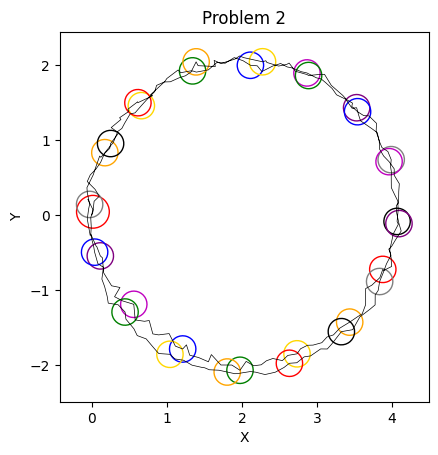

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
from random import random

####utility functions####
def proj_func(x):  #angle wrapping
    x[2] = np.fmod(x[2]+np.pi, 2.0*np.pi)
    if x[2] < 0:
        x[2] = x[2]+2.0*np.pi
    x[2] = x[2] - np.pi
    return x
from matplotlib.patches import Ellipse
def plot_covariance_ellipse(mean, cov, ax=None, n_std=1.0, **kwargs):
    # Calculate the eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)
    # Sort the eigenvalues and eigenvectors in descending order
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    # The angle of rotation of the ellipse (in degrees)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    if ax is None:
        ax = plt.gca()
    ax.add_patch(ellipse)
####end utility functions####

DT = 0.1
SIGMA = 0.05
Rt=SIGMA*np.eye(3)
Qt=Rt

####simulation setup start####
def g(x,command):
    u=command
    xnew = np.zeros(3)
    xnew[0] = x[0] + np.cos(x[2])*u[0]*DT
    xnew[1] = x[1] + np.sin(x[2])*u[0]*DT
    xnew[2] = x[2] + (u[1]*DT)
    return xnew
#####simulation setup end###

def Gt(x, u):
    # Jacobian of the transition function g
    return np.array([[1, 0, -np.sin(x[2]) * u[0] * DT],[0, 1, np.cos(x[2]) * u[0] * DT],[0, 0, 1]])
def Ht(x):
    return np.eye(3)  #the jacobian of h
def h(x):
    return x  # fully observable state

InitCon = np.array([0.,0.,np.pi/2])
U = np.array([1,-0.5])
print(Gt(InitCon,U)) #test
xcurr = InitCon
xest = xcurr
Sigma_est = np.eye(3)  # initialize this
xestlist = xest.reshape(1, -1)  # initialize a list to store your estimated state

colors = ['r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k','r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k','r',
          'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k','r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k']
for i in range(0, 8*32):  # Note that I plot every 0.8 seconds
    # Update prior according to transition (dynamics)
    xbar = g(xest, U)
    G = Gt(xest, U)
    Sigmabar = G @ Sigma_est @ G.T + Qt
    #print(G);print(Sigmabar)

    ####simulation setup start ####
    # system moves with noise
    xcurr = g(xcurr, U+np.random.normal(0,SIGMA,2))
    # take a new measurement
    z=xcurr+np.random.normal(0,SIGMA,3)
    ###simulation end

    Kt = Sigmabar @ Ht(xbar).T @ np.linalg.inv(Ht(xbar) @ Sigmabar @ Ht(xbar).T + Rt)  # compute the Kalman gain
    xest = xbar + Kt @ (z - h(xbar))  #update estimate based on Kt
    xest=proj_func(xest)  # optional angle wrapping
    xestlist=np.vstack([xestlist,xest])

    Sigma_est = (np.eye(3) - Kt @ Ht(xbar)) @ Sigmabar  # Update covariance
    if i % 8 == 0:  # Plot every 0.8 seconds
        plot_covariance_ellipse(xest[0:2], Sigma_est[0:2,0:2], ax=plt.gca(), edgecolor=colors[round(i/8)], facecolor='none', n_std=1)

plt.plot(np.transpose(xestlist)[0],np.transpose(xestlist)[1],'-k',linewidth=0.5)
plt.gca().set_aspect('equal')
plt.title("Problem 2")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Problem 3:

Implement EKF SLAM on the differential drive vehicle model in the environment below using data from the Range-Bearing Sensor defined by the function **rangeBearing(xR)**. Drive the vehicle in a circle around the environment using input $[u_1(t),u_2(t)]= [1,-1/2]$ for $8\pi$ seconds. The system has process noise and measurement noise normally distributed with a variance of $0.05$.


**Turn in: Plots of the map, $m$ with landmark locations and their associated covariance represented by an ellipse, *and* the location and covariance of the robot on the map *when* (1) $t=1sec$, (2)the robot is about to reach loop closure, and (3) when the robot has reached loop closure.**

Note that you will either need to guess and check about the point at which loop closure occurs, or include an if statement with some sort of heuristic that detects that loop closure occurs.


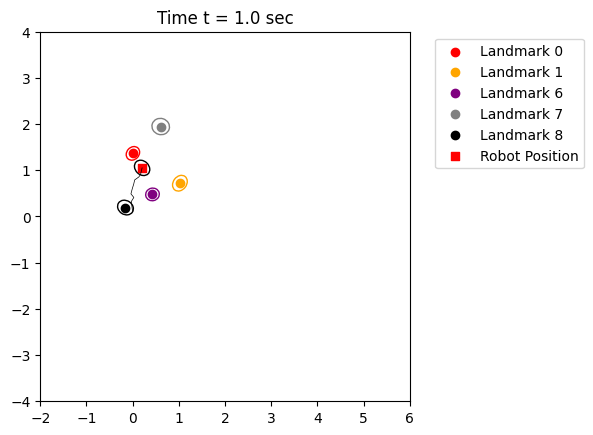

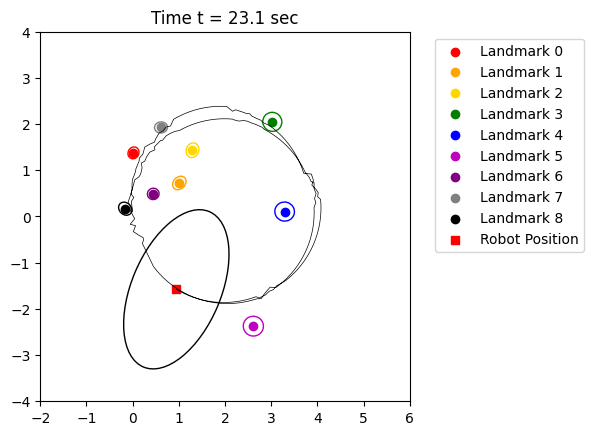

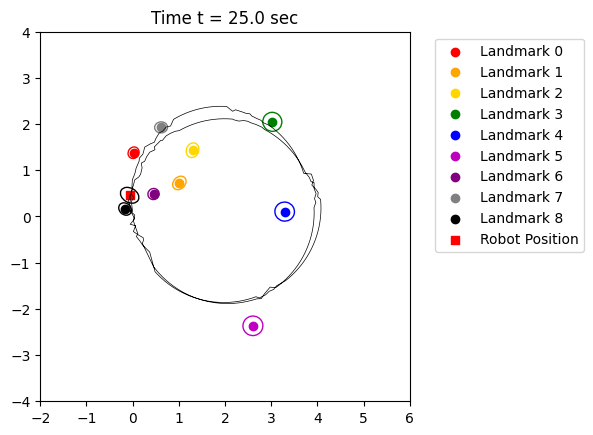

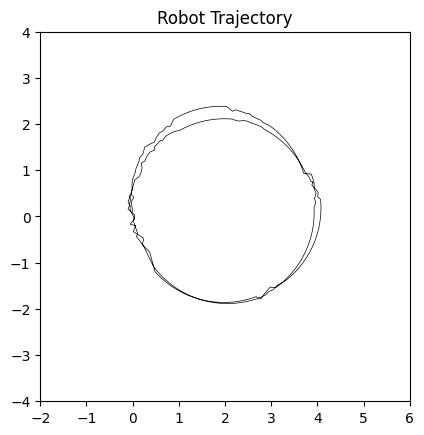

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
from random import random
np.random.seed(1887)
#####utility functions######
def proj_func(x):#angle wrapping function
    if not np.isfinite(x[2]): #I added this because I was getting a runtime error and this fixed it
        x[2] = 0.0
    x[2] = np.fmod(x[2]+np.pi, 2.0*np.pi)
    if(x[2] < 0):
        x[2] = x[2]+2.0*np.pi
    x[2] = x[2] - np.pi
    return x
from matplotlib.patches import Ellipse
def plot_covariance_ellipse(mean, cov, ax=None, n_std=1.0, **kwargs):
    if cov.shape == (2, 2):
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]
        # The angle of rotation of the ellipse (in degrees)
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        width, height = 2 * n_std * np.sqrt(eigvals)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
        if ax is None:
            ax = plt.gca()
        ax.add_patch(ellipse)
#####end utility functions######

#####simulation of sensor do not edit######
#do not use m_actual in ANY of your code
m_actual = np.array([0.1,1.4, 1.1,0.7, 1.4,1.4, 3.2,1.9, 3.2,-0.01, 2.2,-2.3, 0.5,0.5, 0.75,1.9, -0.15,0.2, 2.6,-0.4,])
def rangeBearing(xR):
  delta = [m_actual[2*i:2*i+2]-xR[0:2] for i in range(10)]
  r = [np.linalg.norm(delta[i]) for i in range(10)]
  phi = np.inf*np.ones(10)
  for i in range(10):
    phitemp = np.arctan2(delta[i][1],delta[i][0])-xR[2]
    if r[i]<1.0 and phitemp > -np.pi/2. and phitemp <np.pi/2:
      phi[i] = phitemp;
    else:
      r[i]=np.inf;
      phi[i]=np.inf;
  return r,phi
###simulation of sensor end####
'''
for i in range(10):#plot each of the real landmark locations (you do not need to keep this)
  plt.scatter(*m_actual[2*i:2*i+2], color='red')
plt.gca().set_aspect('equal')
plt.show()
'''

DT = 0.1
SIGMA = 0.05
Rt = SIGMA * np.eye(3)
Qt = SIGMA * np.eye(2)
Fx = np.hstack((np.eye(3), np.zeros((3, 20))))

#####simulation of robot dynamics start######
def f(x, command):
    u = command
    xdot = np.zeros(3)
    xdot[0] = np.cos(x[2]) * u[0]
    xdot[1] = np.sin(x[2]) * u[0]
    xdot[2] = u[1]
    return xdot
#####simulation of roboti dynamics end######

#note that there are many ways to divide this problem and the choices that I made
# are not the best, you should set up functions to compute Jacobians of H and G
#that make the most sense to you!
def Gt(x, u):
    # Jacobian of g
    G = np.eye(23)
    G[0,2] = -np.sin(x[2]) * u[0] * DT
    G[1,2] = np.cos(x[2]) * u[0] * DT
    return G

def h(x):
    # expected observation of each landmark and possible robot pose
    z = []
    for i in range(10):
        mx = x[3 + 2*i]
        my = x[3 + 2*i +1]
        if mx != 0 or my != 0:  # Landmark initialized
            dx = mx - x[0]
            dy = my - x[1]
            r = np.sqrt(dx**2 + dy**2)
            phi = np.arctan2(dy, dx) - x[2]
            # Angle wrapping
            phi_wrap = np.array([0, 0, phi])
            phi_wrap = proj_func(phi_wrap)
            phi = phi_wrap[2]
            z.append([r, phi])
        else:
            z.append([np.inf, np.inf])
    return z

def Jach(x, im):
    # return the Jacobian of h corresponding to each measurement
    H = np.zeros((2, 23))
    mx = x[3 + 2*im]
    my = x[3 + 2*im +1]
    dx = mx - x[0]
    dy = my - x[1]
    q = dx**2 + dy**2
    r = np.sqrt(q)
    if r < 1e-5:
        return H  # Avoid division by zero. Added as result of weird error
    H[0,0] = -dx / r
    H[0,1] = -dy / r
    H[0,3 + 2*im] = dx / r
    H[0,3 + 2*im +1] = dy / r

    H[1,0] = dy / q
    H[1,1] = -dx / q
    H[1,2] = -1
    H[1,3 + 2*im] = -dy / q
    H[1,3 + 2*im +1] = dx / q
    return H

InitCon = np.array([0.,0.,np.pi/2])
U = np.array([1,-0.5])

xcurr = InitCon
xest = np.hstack([InitCon,np.zeros(20)])
Sigma_est = SIGMA*np.eye(23) #needed to remove the 0 to get the ellipses to plot for landmarks
xestlist = xest
#print(xestlist)
colors = ['r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k','c', 'r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k','c',
          'r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k']
#for 8pi seconds or use while loop either will work
for i in range(int(8 * np.pi / DT)):
    #update prior according to transition (dynamics)
    xbar = xest
    xbar[0:3] = xest[0:3] + f(xest[0:3], U) * DT
    xbar = proj_func(xbar)
    G = Gt(xest, U)
    Sigmabar = G @ Sigma_est @ G.T + Fx.T @ Rt @ Fx  # Process covariance prediction

    ####Simulation code#####
    #system moves with noise
    xcurr = xcurr + f(xcurr, U + np.random.normal(0,SIGMA,2)) * DT
    xcurr = proj_func(xcurr)  # Angle wrapping
    #do not use xcurr in your code. Not sure what is meant by this.
    #take a new measurement
    rlist, philist = rangeBearing(xcurr)
    #add sensor noise
    rlist = np.array(rlist) + np.random.normal(0,SIGMA,10)
    philist = np.array(philist) + np.random.normal(0,SIGMA,10)
    # Angle wrapping for measurements
    for idx in range(10):
        phi_wrap = np.array([0, 0, philist[idx]])
        phi_wrap = proj_func(phi_wrap)
        philist[idx] = phi_wrap[2] #not exactly sure when I have to angle wrap.
    ####end simulation code####

    #update xbar according to measurement
    zbar = h(xbar)
    for k in range(10):  #each landmark
        zk = np.array([rlist[k], philist[k]])
        if rlist[k] != np.inf:
            if xbar[3+2*k]==0 and xbar[3+2*k+1]==0:
                # Initialize the landmark
                xbar[3 + 2*k] = xbar[0] + zk[0] * np.cos(xbar[2] + zk[1])
                xbar[3 + 2*k + 1] = xbar[1] + zk[0] * np.sin(xbar[2] + zk[1])
                # Update zbar after initialization
                zbar = h(xbar)
            #compute Hti
            Hti = Jach(xbar, k)
            # Measurement residual with angle wrapping
            delta_z = zk - zbar[k]
            delta_z_angle = np.array([0, 0, delta_z[1]])
            delta_z_angle = proj_func(delta_z_angle)
            delta_z[1] = delta_z_angle[2]
            #compute the Kalman gain
            S = Hti @ Sigmabar @ Hti.T + Qt
            Kt = Sigmabar @ Hti.T @ np.linalg.inv(S)
            #update estimate based on Kt
            xbar = xbar + Kt @ delta_z
            xbar = proj_func(xbar)  # Angle wrapping
            #update covariance
            Sigmabar = (np.eye(23) - Kt @ Hti) @ Sigmabar

    #set final estimate based on this round of measurements
    xest = xbar
    Sigma_est = Sigmabar
    xestlist = np.vstack([xestlist, xest])
    if i == int(1 / DT) or i == int((8 * np.pi / DT) - 20) or i == int((8 * np.pi / DT) - 1):
        plt.figure()
        for k in range(10):  # each landmark
            if xest[3+2*k] != 0 or xest[3+2*k+1] != 0:
                #change indices of xest and Sigma_est below to plot for each landmark
                plot_covariance_ellipse(xest[3+2*k:3+2*k+2], Sigma_est[3+2*k:3+2*k+2,3+2*k:3+2*k+2], ax=plt.gca(), edgecolor=colors[k], facecolor='none', n_std=1)
                plt.scatter(xest[3+2*k], xest[3+2*k+1], c=colors[k], label=f'Landmark {k}')
        # Plot robot pose covariance
        plot_covariance_ellipse(xest[0:2], Sigma_est[0:2,0:2], ax=plt.gca(), edgecolor='black', facecolor='none', n_std=1)
        plt.scatter(xest[0], xest[1], c='red', marker='s', label='Robot Position')
        plt.plot(xestlist[:,0], xestlist[:,1], '-k', linewidth=0.5)
        plt.title(f"Time t = {i*DT:.1f} sec")
        plt.xlim([-2,6])
        plt.ylim([-4,4])
        plt.gca().set_aspect('equal')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

plt.figure()
plt.plot(np.transpose(xestlist)[0],np.transpose(xestlist)[1],'-k',linewidth=0.5)
plt.xlim([-2,6])
plt.ylim([-4,4])
plt.gca().set_aspect('equal')
plt.title('Robot Trajectory')
plt.show()


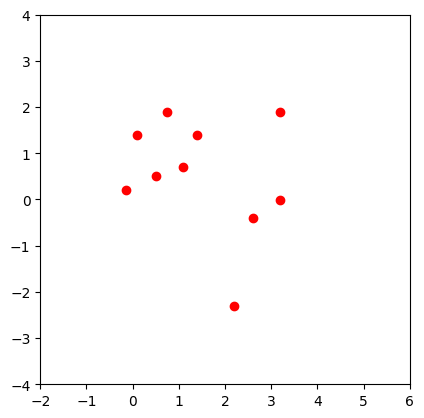

In [8]:
for i in range(10):#plot each of the real landmark locations (you do not need to keep this)
  plt.scatter(*m_actual[2*i:2*i+2], color='red')
plt.gca().set_aspect('equal')
plt.xlim([-2,6])
plt.ylim([-4,4])
plt.show()

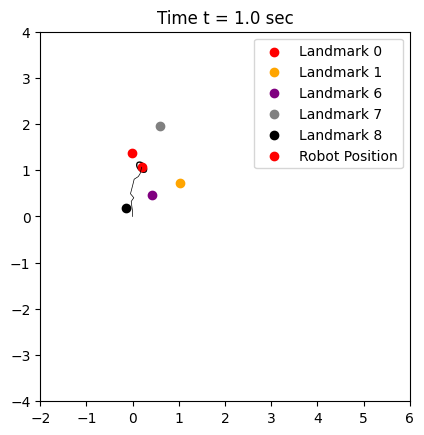

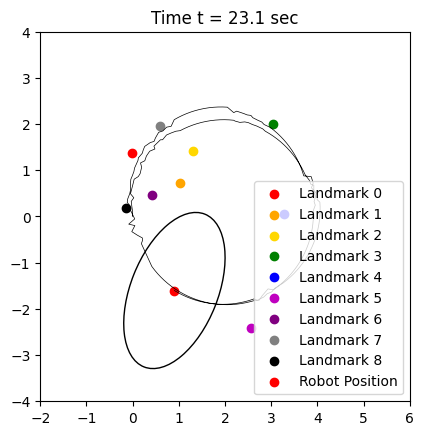

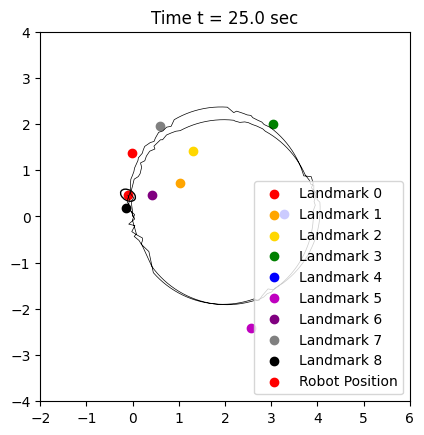

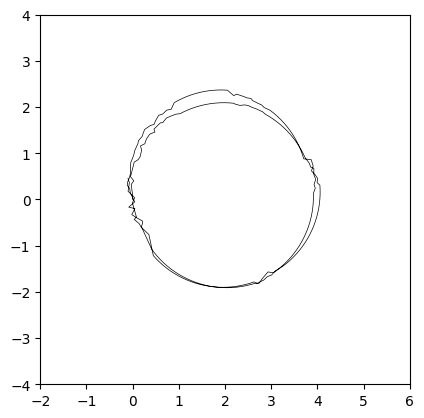

In [9]:
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal
from random import random
np.random.seed(1887)
#####utility functions######
def proj_func(x):#angle wrapping function
    if not np.isfinite(x[2]):
        x[2] = 0.0
    x[2] = np.fmod(x[2]+np.pi, 2.0*np.pi)
    if(x[2] < 0):
        x[2] = x[2]+2.0*np.pi
    x[2] = x[2] - np.pi
from matplotlib.patches import Ellipse
def plot_covariance_ellipse(mean, cov, ax=None, n_std=1.0, **kwargs):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    # The angle of rotation of the ellipse (in degrees)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    if ax is None:
        ax = plt.gca()
    ax.add_patch(ellipse)
#####end utility functions######

#####simulation of sensor do not edit######
#do not use m_actual in ANY of your code
m_actual = np.array([0.1,1.4, 1.1,0.7, 1.4,1.4, 3.2,1.9, 3.2,-0.01, 2.2,-2.3, 0.5,0.5, 0.75,1.9, -0.15,0.2, 2.6,-0.4,])
def rangeBearing(xR):
  delta = [m_actual[2*i:2*i+2]-xR[0:2] for i in range(10)]
  r = [np.linalg.norm(delta[i]) for i in range(10)]
  phi = np.inf*np.ones(10)
  for i in range(10):
    phitemp = np.arctan2(delta[i][1],delta[i][0])-xR[2]
    if r[i]<1.0 and phitemp > -np.pi/2. and phitemp <np.pi/2:
      phi[i] = phitemp;
    else:
      r[i]=np.inf;
      phi[i]=np.inf;
  return r,phi
###simulation of sensor end####
'''
for i in range(10):#plot each of the real landmark locations (you do not need to keep this)
  plt.scatter(*m_actual[2*i:2*i+2], color='red')
plt.gca().set_aspect('equal')
plt.show()
'''

DT = 0.1
SIGMA = 0.05
Rt = SIGMA * np.eye(3)  # Process noise covariance (3x3)
Qt = SIGMA * np.eye(2)  # Measurement noise covariance (2x2)
Fx = np.hstack((np.eye(3), np.zeros((3, 20))))  # (3x23)

#####simulation of robot dynamics start######
def f(x, command):
    u = command
    xdot = np.zeros(3)
    xdot[0] = np.cos(x[2]) * u[0]
    xdot[1] = np.sin(x[2]) * u[0]
    xdot[2] = u[1]
    return xdot
#####simulation of roboti dynamics end######

#note that there are many ways to divide this problem and the choices that I made
# are not the best, you should set up functions to compute Jacobians of H and G
#that make the most sense to you!
def Gt(x, u):
    # Jacobian of the motion model
    G = np.eye(23)
    G[0,2] = -np.sin(x[2]) * u[0] * DT
    G[1,2] = np.cos(x[2]) * u[0] * DT
    return G

def h(x):
    # Expected observation of each landmark and possible robot pose
    z = []
    for i in range(10):
        mx = x[3 + 2*i]
        my = x[3 + 2*i +1]
        if mx != 0 or my != 0:  # Landmark initialized
            dx = mx - x[0]
            dy = my - x[1]
            r = np.sqrt(dx**2 + dy**2)
            phi = np.arctan2(dy, dx) - x[2]
            # Angle wrapping using proj_func
            phi_wrap = np.array([0, 0, phi])
            proj_func(phi_wrap)
            phi = phi_wrap[2]
            z.append([r, phi])
        else:
            z.append([np.inf, np.inf])
    return z

def Jach(x, im):
    # Return the Jacobian of h corresponding to each measurement
    H = np.zeros((2, 23))
    mx = x[3 + 2*im]
    my = x[3 + 2*im +1]
    dx = mx - x[0]
    dy = my - x[1]
    q = dx**2 + dy**2
    r = np.sqrt(q)
    if r < 1e-5:
        return H  # Avoid division by zero
    H[0,0] = -dx / r
    H[0,1] = -dy / r
    H[0,3 + 2*im] = dx / r
    H[0,3 + 2*im +1] = dy / r

    H[1,0] = dy / q
    H[1,1] = -dx / q
    H[1,2] = -1
    H[1,3 + 2*im] = -dy / q
    H[1,3 + 2*im +1] = dx / q
    return H

InitCon = np.array([0.,0.,np.pi/2])
U = np.array([1,-0.5])

xcurr = InitCon.copy()
xest = np.hstack([InitCon,np.zeros(20)])
Sigma_est = 0*SIGMA*np.eye(23)
xestlist = xest.copy().reshape(1, -1)

colors = ['r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k','c', 'r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k','c',
          'r', 'orange', 'gold', 'g', 'b', 'm', 'purple', 'gray','k']
#for 8pi seconds or use while loop either will work
for i in range(int(8 * np.pi / DT)):
    #update prior according to transition (dynamics)
    xbar = xest.copy()
    xbar[0:3] = xest[0:3] + f(xest[0:3], U) * DT
    proj_func(xbar)
    G = Gt(xest, U)
    Sigmabar = G @ Sigma_est @ G.T + Fx.T @ Rt @ Fx  # Process covariance prediction

    ####Simulation code#####
    #system moves with noise
    xcurr = xcurr + f(xcurr, U + np.random.normal(0,SIGMA,2)) * DT
    proj_func(xcurr)  # Angle wrapping
    #do not use xcurr in your code
    #take a new measurement
    rlist, philist = rangeBearing(xcurr)
    #add sensor noise
    rlist = np.array(rlist) + np.random.normal(0,SIGMA,10)
    philist = np.array(philist) + np.random.normal(0,SIGMA,10)
    # Angle wrapping for measurements
    for idx in range(10):
        phi_wrap = np.array([0, 0, philist[idx]])
        proj_func(phi_wrap)
        philist[idx] = phi_wrap[2]
    ####end simulation code####

    #update xbar according to measurement
    zbar = h(xbar)
    for k in range(10):  # each landmark
        zk = np.array([rlist[k], philist[k]])
        if rlist[k] != np.inf:
            if xbar[3+2*k]==0 and xbar[3+2*k+1]==0:
                # Initialize the landmark
                xbar[3 + 2*k] = xbar[0] + zk[0] * np.cos(xbar[2] + zk[1])
                xbar[3 + 2*k + 1] = xbar[1] + zk[0] * np.sin(xbar[2] + zk[1])
                # Update zbar after initialization
                zbar = h(xbar)
            if not np.isinf(zbar[k][0]):
                #compute Hti
                Hti = Jach(xbar, k)
                # Measurement residual with angle wrapping
                delta_z = zk - zbar[k]
                delta_z_angle = np.array([0, 0, delta_z[1]])
                proj_func(delta_z_angle)
                delta_z[1] = delta_z_angle[2]
                #compute the Kalman gain
                S = Hti @ Sigmabar @ Hti.T + Qt
                Kt = Sigmabar @ Hti.T @ np.linalg.inv(S)
                #update estimate based on Kt
                xbar = xbar + Kt @ delta_z
                proj_func(xbar)  # Angle wrapping
                #update covariance
                Sigmabar = (np.eye(23) - Kt @ Hti) @ Sigmabar
    #set final estimate based on this round of measurements
    xest = xbar.copy()
    Sigma_est = Sigmabar.copy()
    xestlist = np.vstack([xestlist, xest])
    if i == int(1 / DT) or i == int((8 * np.pi / DT) - 20) or i == int((8 * np.pi / DT) - 1):
        for k in range(10):  # each landmark
            if xest[3+2*k] != 0 or xest[3+2*k+1] != 0:
                #change indices of xest and Sigma_est below to plot for each landmark
                plot_covariance_ellipse(xest[3+2*k:3+2*k+2], Sigma_est[3+2*k:3+2*k+2,3+2*k:3+2*k+2], ax=plt.gca(), edgecolor=colors[k], facecolor='none', n_std=1)
                plt.scatter(xest[3+2*k], xest[3+2*k+1], c=colors[k], label=f'Landmark {k}')
                plt.xlim([-2,6])
                plt.ylim([-4,4])
        # Plot robot pose covariance
        plot_covariance_ellipse(xest[0:2], Sigma_est[0:2,0:2], ax=plt.gca(), edgecolor='black', facecolor='none', n_std=1)
        plt.plot(xestlist[:,0], xestlist[:,1], '-k', linewidth=0.5)
        plt.scatter(xest[0], xest[1], c='red', label='Robot Position')
        plt.title(f"Time t = {i*DT:.1f} sec")
        plt.gca().set_aspect('equal')
        plt.legend()
        plt.xlim([-2,6])
        plt.ylim([-4,4])
        plt.show()

plt.plot(np.transpose(xestlist)[0],np.transpose(xestlist)[1],'-k',linewidth=0.5)
plt.gca().set_aspect('equal')
plt.xlim([-2,6])
plt.ylim([-4,4])
plt.show()
'''